In [1]:
!pip install tensorflow
!pip install obspy

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
DEPRECATION: devscripts 2.22.1ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


DEPRECATION: devscripts 2.22.1ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
import os
import pandas as pd
import numpy as np
from obspy import read

# 시계열 데이터 준비 함수 (여러 파일 처리, 라벨 데이터셋 사용)
def load_and_preprocess_data_slicing(data_dir, label_csv_path, time_step=6000, overlap_step=100):
    # 카탈로그 라벨 데이터셋 로드
    label_df = pd.read_csv(label_csv_path)
    
    X, y = [], []
    for file_name in os.listdir(data_dir):
        if file_name.endswith('.mseed') and ('padded' in file_name):  # mseed 파일 처리
            file_path = os.path.join(data_dir, file_name)
            stream = read(file_path)  # mseed 파일 읽기
            tr = stream[0]  # 트레이스 (Trace) 추출
            velocity = tr.data  # mseed 파일의 진폭 데이터를 velocity로 사용
            
            # time_rel 추출 (초 단위로 변환)
            sampling_rate = tr.stats.sampling_rate
            time_rel = np.arange(0, len(velocity)) / sampling_rate
            
            # 데이터 정규화 (옵션)
            velocity = (velocity - np.min(velocity)) / (np.max(velocity) - np.min(velocity))

            # 라벨 데이터에서 해당 파일의 time_rel 값을 가져오기
            label_row = label_df[label_df['filename']+'_padded.mseed' == file_name]
            if not label_row.empty:
                event_time_rel = label_row['time_rel(sec)'].values[0]  # 라벨 (지진파 시작점)
                
                # event_time_rel에 해당하는 인덱스 찾기
                event_index = int(event_time_rel * sampling_rate)

                # 슬라이싱 기준을 event_index에 맞춰서 샘플링
                # start_index 범위 조정: event_index - (time_step // 2)에서 event_index까지 슬라이싱
                for start_index in range(max(0, event_index - time_step // 2), min(len(velocity) - time_step + 1, event_index + 1)):
                    end_index = start_index + time_step
                    
                    # 슬라이싱이 가능한 경우에만 추가
                    if end_index <= len(velocity):
                        X.append(velocity[start_index:end_index])
                        y.append(event_time_rel)  # 해당 파일의 라벨을 y로 설정

                # 이후 단계에서 시작 지점을 이동할 수 있도록 overlap_step을 사용하여 샘플 생성
                for start_index in range(max(0, event_index - time_step // 2), min(len(velocity) - time_step + 1, event_index + 1), overlap_step):
                    end_index = start_index + time_step
                    
                    # 슬라이싱이 가능한 경우에만 추가
                    if end_index <= len(velocity):
                        X.append(velocity[start_index:end_index])
                        y.append(event_time_rel)  # 해당 파일의 라벨을 y로 설정
    
    return np.array(X), np.array(y)

In [3]:
# 데이터가 저장된 디렉토리 경로
train_data_dir = './seismic_detection/data_copy/lunar/training/data/S12_GradeA/'
train_label_csv_path = './seismic_detection/data_copy/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv'

test_data_dir = './seismic_detection/data_copy/lunar/training/testset/'

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# 데이터 로드 및 전처리 함수 (이전에 정의한 함수 사용)
print("학습 데이터 로딩 및 전처리 중...")
X_train, y_train = load_and_preprocess_data_slicing(train_data_dir, train_label_csv_path)

print("validation 데이터 로딩 및 전처리 중...")
X_test, y_test = load_and_preprocess_data_slicing(test_data_dir, train_label_csv_path)

print("X_train, y_train 데이터 크기")
print(X_train.shape, y_train.shape)

print("X_test, y_test 데이터 크기")
print(X_test.shape, y_test.shape)

# 데이터 정규화
print("데이터 정규화 중...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# 1D CNN 모델 정의
def create_1d_cnn_model(input_shape):
    print("1D CNN 모델 생성 중...")
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=256, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1)  # 출력층: 이벤트 시작 시간 예측
    ])
    return model

# 모델 컴파일
print("모델 컴파일 중...")
model = create_1d_cnn_model((X_train.shape[1], 1))
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# 조기 종료 콜백
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
print("모델 학습 시작...")
history = model.fit(
    X_train_scaled, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

print("모델 학습 완료.")


2024-10-05 12:20:15.895298: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-05 12:20:15.913439: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-05 12:20:15.933936: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-05 12:20:15.940181: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-05 12:20:15.954843: I tensorflow/core/platform/cpu_feature_guar

학습 데이터 로딩 및 전처리 중...
validation 데이터 로딩 및 전처리 중...
X_train, y_train 데이터 크기
(221336, 6000) (221336,)
X_test, y_test 데이터 크기
(9096, 6000) (9096,)
데이터 정규화 중...
모델 컴파일 중...
1D CNN 모델 생성 중...


/home/work/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-10-05 12:20:42.883635: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31364 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:86:00.0, compute capability: 7.0


모델 학습 시작...
Epoch 1/30


I0000 00:00:1728130854.942519   43662 service.cc:146] XLA service 0x7f1cb4005980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728130854.942548   43662 service.cc:154]   StreamExecutor device (0): CUDA GPU, Compute Capability 7.0
2024-10-05 12:20:54.979433: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-05 12:20:55.177392: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


   5/5534 ━━━━━━━━━━━━━━━━━━━━ 2:45 30ms/step - loss: 1940422912.0000

I0000 00:00:1728130857.743771   43662 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5534/5534 ━━━━━━━━━━━━━━━━━━━━ 176s 31ms/step - loss: 416864768.0000 - val_loss: 1108657536.0000
Epoch 2/30
5534/5534 ━━━━━━━━━━━━━━━━━━━━ 166s 30ms/step - loss: 83472416.0000 - val_loss: 1059412800.0000
Epoch 3/30
5534/5534 ━━━━━━━━━━━━━━━━━━━━ 166s 30ms/step - loss: 71060728.0000 - val_loss: 1036037248.0000
Epoch 4/30
5534/5534 ━━━━━━━━━━━━━━━━━━━━ 166s 30ms/step - loss: 66165064.0000 - val_loss: 845875200.0000
Epoch 5/30
5534/5534 ━━━━━━━━━━━━━━━━━━━━ 166s 30ms/step - loss: 62902972.0000 - val_loss: 981002368.0000
Epoch 6/30
5534/5534 ━━━━━━━━━━━━━━━━━━━━ 166s 30ms/step - loss: 60770280.0000 - val_loss: 814071040.0000
Epoch 7/30
5534/5534 ━━━━━━━━━━━━━━━━━━━━ 166s 30ms/step - loss: 60050668.0000 - val_loss: 954492480.0000
Epoch 8/30
5534/5534 ━━━━━━━━━━━━━━━━━━━━ 166s 30ms/step - loss: 59654052.0000 - val_loss: 977567296.0000
Epoch 9/30
5534/5534 ━━━━━━━━━━━━━━━━━━━━ 166s 30ms/step - loss: 60007932.0000 - val_loss: 912188160.0000
Epoch 10/30
5534/5534 ━━━━━━━━━━━━━━━━━━━━ 166s 30ms/

In [5]:
# 예측
print("예측 수행 중")
predictions = model.predict(X_test_scaled)

# 결과 비교
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': predictions.flatten()
})
print(results_df.head())

# MSE 계산
mse = np.mean((results_df['Actual'] - results_df['Predicted'])**2)
print(f"Mean Squared Error: {mse}")

예측 수행 중
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
    Actual     Predicted
0  66060.0  47881.187500
1  66060.0  50367.488281
2  66060.0  49460.890625
3  66060.0  52680.125000
4  66060.0  52581.988281
Mean Squared Error: 431481087.9858298


In [10]:
results_df.head(20)

,Actual,Predicted
0,66060.0,47881.187500
1,66060.0,50367.488281
2,66060.0,49460.890625
3,66060.0,52680.125000
4,66060.0,52581.988281
5,66060.0,53813.230469
6,66060.0,49554.906250
7,66060.0,50388.566406
8,66060.0,50061.882812
9,66060.0,48204.007812


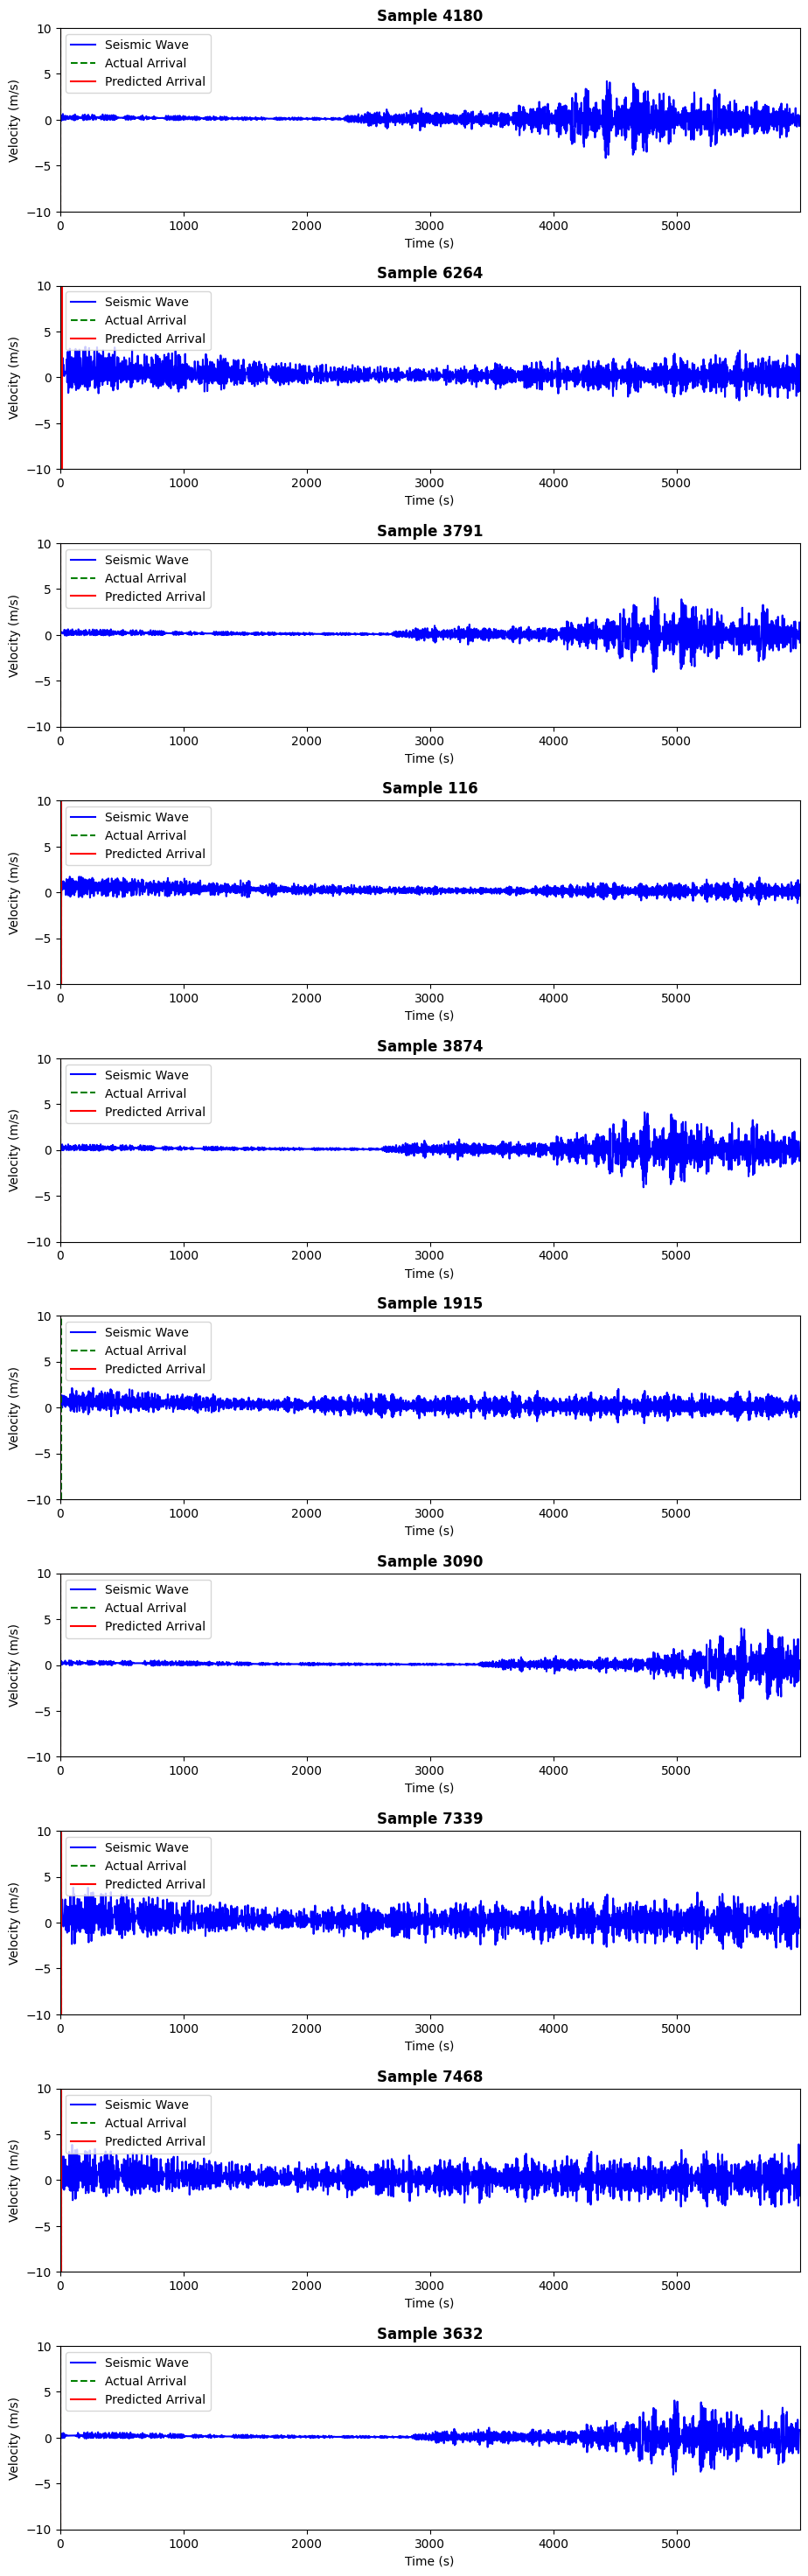

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import random

# 랜덤으로 10개의 데이터를 선택
num_samples = 10
random_indices = random.sample(range(len(X_test_scaled)), num_samples)

# 시각화
fig, axs = plt.subplots(num_samples, 1, figsize=(10, 3*num_samples))
fig.tight_layout(pad=4.0)

for i, idx in enumerate(random_indices):
    tr_data = X_test_scaled[idx]  # 스케일링된 지진파 데이터
    tr_length = len(tr_data)  # 지진파 데이터 길이
    arrival = int(predictions[idx] * (1/tr_length))  # 예측된 y값을 샘플 인덱스로 변환
    actual_arrival = int(y_test[idx] * (1/tr_length))  # 실제 y값을 샘플 인덱스로 변환
    
    tr_times = np.arange(0, tr_length)

    # 랜덤하게 선택된 파일명을 title로 출력
    test_filename = f"Sample {idx + 1}"

    # 지진파 시각화
    axs[i].plot(tr_times, tr_data, label='Seismic Wave', color='blue')
    axs[i].axvline(x=actual_arrival, color='green', linestyle='--', label='Actual Arrival')  # 실제 지진파 시작점
    axs[i].axvline(x=arrival, color='red', label='Predicted Arrival')  # 예측된 지진파 시작점
    
    axs[i].legend(loc='upper left')
    axs[i].set_xlim([min(tr_times), max(tr_times)])
    axs[i].set_ylim([-10, 10]) 
    axs[i].set_ylabel('Velocity (m/s)')
    axs[i].set_xlabel('Time (s)')
    axs[i].set_title(f'{test_filename}', fontweight='bold')

plt.show()


In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 5998, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2999, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2997, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1498, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1496, 256)      │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 748, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 191488)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    24,510,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,902,725 (281.92 MB)

 Trainable params: 24,634,241 (93.97 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 49,268,484 (187.94 MB)

In [9]:
model.save('model.h5')